https://machinelearningmastery.com/imbalanced-classification-of-good-and-bad-credit/

https://raw.githubusercontent.com/jbrownlee/Datasets/master/german.csv

df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/german.csv')
df

In [1]:
# load and summarize the dataset
from pandas import read_csv
from collections import Counter
# define the dataset location
filename = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/german.csv'
# load the csv file as a data frame
dataframe = read_csv(filename, header=None)
# summarize the shape of the dataset
print(dataframe.shape)
# summarize the class distribution
target = dataframe.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
	per = v / len(target) * 100
	print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

(1000, 21)
Class=1, Count=700, Percentage=70.000%
Class=2, Count=300, Percentage=30.000%


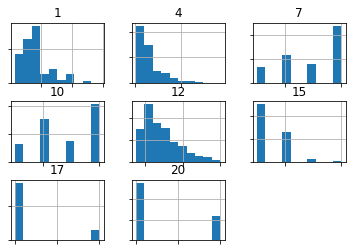

In [4]:
# create histograms of numeric input variables
from pandas import read_csv
from matplotlib import pyplot
# define the dataset location
filename = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/german.csv'
# load the csv file as a data frame
df = read_csv(filename, header=None)
# select columns with numerical data types
num_ix = df.select_dtypes(include=['int64', 'float64']).columns
# select a subset of the dataframe with the chosen columns
subset = df[num_ix]
# create a histogram plot of each numeric variable
ax = subset.hist()
# disable axis labels to avoid the clutter
for axis in ax.flatten():
	axis.set_xticklabels([])
	axis.set_yticklabels([])
# show the plot
pyplot.show()

Model Test and Baseline Result

We will evaluate candidate models using repeated stratified k-fold cross-validation.

The k-fold cross-validation procedure provides a good general estimate of model performance that is not too optimistically biased, at least compared to a single train-test split. We will use k=10, meaning each fold will contain about 1000/10 or 100 examples.

Stratified means that each fold will contain the same mixture of examples by class, that is about 70 percent to 30 percent good to bad customers. Repeated means that the evaluation process will be performed multiple times to help avoid fluke results and better capture the variance of the chosen model. We will use three repeats.

This means a single model will be fit and evaluated 10 * 3 or 30 times and the mean and standard deviation of these runs will be reported.

This can be achieved using the RepeatedStratifiedKFold scikit-learn class.

We will predict class labels of whether a customer is good or not. Therefore, we need a measure that is appropriate for evaluating the predicted class labels.

The focus of the task is on the positive class (bad customers). Precision and recall are a good place to start. Maximizing precision will minimize the false positives and maximizing recall will minimize the false negatives in the predictions made by a model.

Precision = TruePositives / (TruePositives + FalsePositives)
Recall = TruePositives / (TruePositives + FalseNegatives)
Using the F-Measure will calculate the harmonic mean between precision and recall. This is a good single number that can be used to compare and select a model on this problem. The issue is that false negatives are more damaging than false positives.

F-Measure = (2 * Precision * Recall) / (Precision + Recall)
Remember that false negatives on this dataset are cases of a bad customer being marked as a good customer and being given a loan. False positives are cases of a good customer being marked as a bad customer and not being given a loan.

False Negative: Bad Customer (class 1) predicted as a Good Customer (class 0).
False Positive: Good Customer (class 0) predicted as a Bad Customer (class 1).
False negatives are more costly to the bank than false positives.

Cost(False Negatives) > Cost(False Positives)
Put another way, we are interested in the F-measure that will summarize a model’s ability to minimize misclassification errors for the positive class, but we want to favor models that are better are minimizing false negatives over false positives.

This can be achieved by using a version of the F-measure that calculates a weighted harmonic mean of precision and recall but favors higher recall scores over precision scores. This is called the Fbeta-measure, a generalization of F-measure, where “beta” is a parameter that defines the weighting of the two scores.

Fbeta-Measure = ((1 + beta^2) * Precision * Recall) / (beta^2 * Precision + Recall)
A beta value of 2 will weight more attention on recall than precision and is referred to as the F2-measure.

F2-Measure = ((1 + 2^2) * Precision * Recall) / (2^2 * Precision + Recall)
We will use this measure to evaluate models on the German credit dataset. This can be achieved using the fbeta_score() scikit-learn function.

We can define a function to load the dataset and split the columns into input and output variables. We will one-hot encode the categorical variables and label encode the target variable. You might recall that a one-hot encoding replaces the categorical variable with one new column for each value of the variable and marks values with a 1 in the column for that value.

In [7]:
# test harness and baseline model evaluation for the german credit dataset
from collections import Counter
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier

# load the dataset
def load_dataset(full_path):
	# load the dataset as a numpy array
	dataframe = read_csv(full_path, header=None)
	# split into inputs and outputs
	last_ix = len(dataframe.columns) - 1
	X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
	# select categorical features
	cat_ix = X.select_dtypes(include=['object', 'bool']).columns
	# one hot encode cat features only
	ct = ColumnTransformer([('o',OneHotEncoder(),cat_ix)], remainder='passthrough')
	X = ct.fit_transform(X)
	# label encode the target variable to have the classes 0 and 1
	y = LabelEncoder().fit_transform(y)
	return X, y

# calculate f2 score
def f2(y_true, y_pred):
	return fbeta_score(y_true, y_pred, beta=2)

# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# define the model evaluation metric
	metric = make_scorer(f2)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
	return scores

# define the location of the dataset
full_path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/german.csv'
# load the dataset
X, y = load_dataset(full_path)
# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))
# define the reference model
model = DummyClassifier(strategy='constant', constant=1)
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean F2: %.3f (%.3f)' % (mean(scores), std(scores)))

(1000, 61) (1000,) Counter({0: 700, 1: 300})
Mean F2: 0.682 (0.000)


Evaluate Models

In this section, we will evaluate a suite of different techniques on the dataset using the test harness developed in the previous section.

The goal is to both demonstrate how to work through the problem systematically and to demonstrate the capability of some techniques designed for imbalanced classification problems.

The reported performance is good, but not highly optimized (e.g. hyperparameters are not tuned).

Can you do better? If you can achieve better F2-Measure performance using the same test harness, I’d love to hear about it. Let me know in the comments below.

Evaluate Machine Learning Algorithms

Let’s start by evaluating a mixture of probabilistic machine learning models on the dataset.

It can be a good idea to spot check a suite of different linear and nonlinear algorithms on a dataset to quickly flush out what works well and deserves further attention, and what doesn’t.

We will evaluate the following machine learning models on the German credit dataset:

Logistic Regression (LR)
Linear Discriminant Analysis (LDA)
Naive Bayes (NB)
Gaussian Process Classifier (GPC)
Support Vector Machine (SVM)
We will use mostly default model hyperparameters.

We will define each model in turn and add them to a list so that we can evaluate them sequentially. The get_models() function below defines the list of models for evaluation, as well as a list of model short names for plotting the results later.

>LR 0.498 (0.072)
>LDA 0.519 (0.072)
>NB 0.639 (0.049)
>GPC 0.219 (0.061)
>SVM 0.436 (0.077)


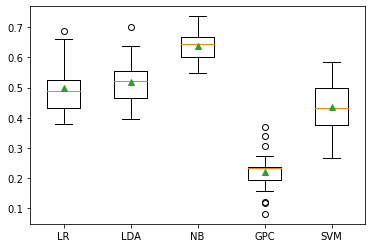

In [9]:
# spot check machine learning algorithms on the german credit dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC

# load the dataset
def load_dataset(full_path):
	# load the dataset as a numpy array
	dataframe = read_csv(full_path, header=None)
	# split into inputs and outputs
	last_ix = len(dataframe.columns) - 1
	X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
	# select categorical and numerical features
	cat_ix = X.select_dtypes(include=['object', 'bool']).columns
	num_ix = X.select_dtypes(include=['int64', 'float64']).columns
	# label encode the target variable to have the classes 0 and 1
	y = LabelEncoder().fit_transform(y)
	return X.values, y, cat_ix, num_ix

# calculate f2-measure
def f2_measure(y_true, y_pred):
	return fbeta_score(y_true, y_pred, beta=2)

# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# define the model evaluation metric
	metric = make_scorer(f2_measure)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
	return scores

# define models to test
def get_models():
	models, names = list(), list()
	# LR
	models.append(LogisticRegression(solver='liblinear'))
	names.append('LR')
	# LDA
	models.append(LinearDiscriminantAnalysis())
	names.append('LDA')
	# NB
	models.append(GaussianNB())
	names.append('NB')
	# GPC
	models.append(GaussianProcessClassifier())
	names.append('GPC')
	# SVM
	models.append(SVC(gamma='scale'))
	names.append('SVM')
	return models, names

# define the location of the dataset
full_path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/german.csv'
# load the dataset
X, y, cat_ix, num_ix = load_dataset(full_path)
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
	# one hot encode categorical, normalize numerical
	ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',MinMaxScaler(),num_ix)])
	# wrap the model i a pipeline
	pipeline = Pipeline(steps=[('t',ct),('m',models[i])])
	# evaluate the model and store results
	scores = evaluate_model(X, y, pipeline)
	results.append(scores)
	# summarize and store
	print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Evaluate Undersampling

Undersampling is perhaps the least widely used technique when addressing an imbalanced classification task as most of the focus is put on oversampling the majority class with SMOTE.

Undersampling can help to remove examples from the majority class along the decision boundary that make the problem challenging for classification algorithms.

In this experiment we will test the following undersampling algorithms:

Tomek Links (TL)
Edited Nearest Neighbors (ENN)
Repeated Edited Nearest Neighbors (RENN)
One Sided Selection (OSS)
Neighborhood Cleaning Rule (NCR)
The Tomek Links and ENN methods select examples from the majority class to delete, whereas OSS and NCR both select examples to keep and examples to delete. We will use the balanced version of the logistic regression algorithm to test each undersampling method, to keep things simple.

The get_models() function from the previous section can be updated to return a list of undersampling techniques to test with the logistic regression algorithm. We use the implementations of these algorithms from the imbalanced-learn library.

The updated version of the get_models() function defining the undersampling methods is listed below.

>TL 0.669 (0.057)
>ENN 0.706 (0.048)
>RENN 0.714 (0.041)
>OSS 0.668 (0.058)
>NCR 0.693 (0.052)


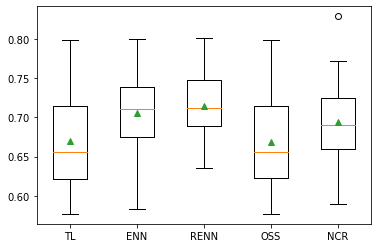

In [10]:
# evaluate undersampling with logistic regression on the imbalanced german credit dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import OneSidedSelection

# load the dataset
def load_dataset(full_path):
	# load the dataset as a numpy array
	dataframe = read_csv(full_path, header=None)
	# split into inputs and outputs
	last_ix = len(dataframe.columns) - 1
	X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
	# select categorical and numerical features
	cat_ix = X.select_dtypes(include=['object', 'bool']).columns
	num_ix = X.select_dtypes(include=['int64', 'float64']).columns
	# label encode the target variable to have the classes 0 and 1
	y = LabelEncoder().fit_transform(y)
	return X.values, y, cat_ix, num_ix

# calculate f2-measure
def f2_measure(y_true, y_pred):
	return fbeta_score(y_true, y_pred, beta=2)

# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# define the model evaluation metric
	metric = make_scorer(f2_measure)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
	return scores

# define undersampling models to test
def get_models():
	models, names = list(), list()
	# TL
	models.append(TomekLinks())
	names.append('TL')
	# ENN
	models.append(EditedNearestNeighbours())
	names.append('ENN')
	# RENN
	models.append(RepeatedEditedNearestNeighbours())
	names.append('RENN')
	# OSS
	models.append(OneSidedSelection())
	names.append('OSS')
	# NCR
	models.append(NeighbourhoodCleaningRule())
	names.append('NCR')
	return models, names

# define the location of the dataset
full_path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/german.csv'
# load the dataset
X, y, cat_ix, num_ix = load_dataset(full_path)
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
	# define model to evaluate
	model = LogisticRegression(solver='liblinear', class_weight='balanced')
	# one hot encode categorical, normalize numerical
	ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',MinMaxScaler(),num_ix)])
	# scale, then undersample, then fit model
	pipeline = Pipeline(steps=[('t',ct), ('s', models[i]), ('m',model)])
	# evaluate the model and store results
	scores = evaluate_model(X, y, pipeline)
	results.append(scores)
	# summarize and store
	print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Further Model Improvements

This is a new section that provides a minor departure to the above section. Here, we will test specific models that result in a further lift in F2-measure performance and I will update this section as new models are reported/discovered.

Improvement #1: InstanceHardnessThreshold

An F2-measure of about 0.727 can be achieved using balanced Logistic Regression with InstanceHardnessThreshold undersampling.

In [11]:
# improve performance on the imbalanced german credit dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import InstanceHardnessThreshold

# load the dataset
def load_dataset(full_path):
	# load the dataset as a numpy array
	dataframe = read_csv(full_path, header=None)
	# split into inputs and outputs
	last_ix = len(dataframe.columns) - 1
	X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
	# select categorical and numerical features
	cat_ix = X.select_dtypes(include=['object', 'bool']).columns
	num_ix = X.select_dtypes(include=['int64', 'float64']).columns
	# label encode the target variable to have the classes 0 and 1
	y = LabelEncoder().fit_transform(y)
	return X.values, y, cat_ix, num_ix

# calculate f2-measure
def f2_measure(y_true, y_pred):
	return fbeta_score(y_true, y_pred, beta=2)

# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# define the model evaluation metric
	metric = make_scorer(f2_measure)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
	return scores

# define the location of the dataset
full_path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/german.csv'
# load the dataset
X, y, cat_ix, num_ix = load_dataset(full_path)
# define model to evaluate
model = LogisticRegression(solver='liblinear', class_weight='balanced')
# define the data sampling
sampling = InstanceHardnessThreshold()
# one hot encode categorical, normalize numerical
ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',MinMaxScaler(),num_ix)])
# scale, then sample, then fit model
pipeline = Pipeline(steps=[('t',ct), ('s', sampling), ('m',model)])
# evaluate the model and store results
scores = evaluate_model(X, y, pipeline)
print('%.3f (%.3f)' % (mean(scores), std(scores)))

0.724 (0.034)


Improvement #2: SMOTEENN

An F2-measure of about 0.730 can be achieved using LDA with SMOTEENN, where the ENN parameter is set to an ENN instance with sampling_strategy set to majority.

In [12]:
# improve performance on the imbalanced german credit dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

# load the dataset
def load_dataset(full_path):
	# load the dataset as a numpy array
	dataframe = read_csv(full_path, header=None)
	# split into inputs and outputs
	last_ix = len(dataframe.columns) - 1
	X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
	# select categorical and numerical features
	cat_ix = X.select_dtypes(include=['object', 'bool']).columns
	num_ix = X.select_dtypes(include=['int64', 'float64']).columns
	# label encode the target variable to have the classes 0 and 1
	y = LabelEncoder().fit_transform(y)
	return X.values, y, cat_ix, num_ix

# calculate f2-measure
def f2_measure(y_true, y_pred):
	return fbeta_score(y_true, y_pred, beta=2)

# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# define the model evaluation metric
	metric = make_scorer(f2_measure)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
	return scores

# define the location of the dataset
full_path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/german.csv'
# load the dataset
X, y, cat_ix, num_ix = load_dataset(full_path)
# define model to evaluate
model = LinearDiscriminantAnalysis()
# define the data sampling
sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
# one hot encode categorical, normalize numerical
ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',MinMaxScaler(),num_ix)])
# scale, then sample, then fit model
pipeline = Pipeline(steps=[('t',ct), ('s', sampling), ('m',model)])
# evaluate the model and store results
scores = evaluate_model(X, y, pipeline)
print('%.3f (%.3f)' % (mean(scores), std(scores)))

0.728 (0.045)


Improvement #3: SMOTEENN with StandardScaler and RidgeClassifier

An F2-measure of about 0.741 can be achieved with further improvements to the SMOTEENN using a RidgeClassifier instead of LDA and using a StandardScaler for the numeric inputs instead of a MinMaxScaler.

In [13]:
# improve performance on the imbalanced german credit dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import RidgeClassifier
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

# load the dataset
def load_dataset(full_path):
	# load the dataset as a numpy array
	dataframe = read_csv(full_path, header=None)
	# split into inputs and outputs
	last_ix = len(dataframe.columns) - 1
	X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
	# select categorical and numerical features
	cat_ix = X.select_dtypes(include=['object', 'bool']).columns
	num_ix = X.select_dtypes(include=['int64', 'float64']).columns
	# label encode the target variable to have the classes 0 and 1
	y = LabelEncoder().fit_transform(y)
	return X.values, y, cat_ix, num_ix

# calculate f2-measure
def f2_measure(y_true, y_pred):
	return fbeta_score(y_true, y_pred, beta=2)

# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# define the model evaluation metric
	metric = make_scorer(f2_measure)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
	return scores

# define the location of the dataset
full_path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/german.csv'
# load the dataset
X, y, cat_ix, num_ix = load_dataset(full_path)
# define model to evaluate
model = RidgeClassifier()
# define the data sampling
sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
# one hot encode categorical, normalize numerical
ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',StandardScaler(),num_ix)])
# scale, then sample, then fit model
pipeline = Pipeline(steps=[('t',ct), ('s', sampling), ('m',model)])
# evaluate the model and store results
scores = evaluate_model(X, y, pipeline)
print('%.3f (%.3f)' % (mean(scores), std(scores)))

0.735 (0.040)


Make Prediction on New Data

Given the variance in results, a selection of any of the undersampling methods is probably sufficient. In this case, we will select logistic regression with Repeated ENN.

This model had an F2-measure of about about 0.716 on our test harness.

We will use this as our final model and use it to make predictions on new data.

First, we can define the model as a pipeline.

In [14]:
# fit a model and make predictions for the german credit dataset
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RepeatedEditedNearestNeighbours

# load the dataset
def load_dataset(full_path):
	# load the dataset as a numpy array
	dataframe = read_csv(full_path, header=None)
	# split into inputs and outputs
	last_ix = len(dataframe.columns) - 1
	X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
	# select categorical and numerical features
	cat_ix = X.select_dtypes(include=['object', 'bool']).columns
	num_ix = X.select_dtypes(include=['int64', 'float64']).columns
	# label encode the target variable to have the classes 0 and 1
	y = LabelEncoder().fit_transform(y)
	return X.values, y, cat_ix, num_ix

# define the location of the dataset
full_path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/german.csv'
# load the dataset
X, y, cat_ix, num_ix = load_dataset(full_path)
# define model to evaluate
model = LogisticRegression(solver='liblinear', class_weight='balanced')
# one hot encode categorical, normalize numerical
ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',MinMaxScaler(),num_ix)])
# scale, then undersample, then fit model
pipeline = Pipeline(steps=[('t',ct), ('s', RepeatedEditedNearestNeighbours()), ('m',model)])
# fit the model
pipeline.fit(X, y)
# evaluate on some good customers cases (known class 0)
print('Good Customers:')
data = [['A11', 6, 'A34', 'A43', 1169, 'A65', 'A75', 4, 'A93', 'A101', 4, 'A121', 67, 'A143', 'A152', 2, 'A173', 1, 'A192', 'A201'],
	['A14', 12, 'A34', 'A46', 2096, 'A61', 'A74', 2, 'A93', 'A101', 3, 'A121', 49, 'A143', 'A152', 1, 'A172', 2, 'A191', 'A201'],
	['A11', 42, 'A32', 'A42', 7882, 'A61', 'A74', 2, 'A93', 'A103', 4, 'A122', 45, 'A143', 'A153', 1, 'A173', 2, 'A191', 'A201']]
for row in data:
	# make prediction
	yhat = pipeline.predict([row])
	# get the label
	label = yhat[0]
	# summarize
	print('>Predicted=%d (expected 0)' % (label))
# evaluate on some bad customers (known class 1)
print('Bad Customers:')
data = [['A13', 18, 'A32', 'A43', 2100, 'A61', 'A73', 4, 'A93', 'A102', 2, 'A121', 37, 'A142', 'A152', 1, 'A173', 1, 'A191', 'A201'],
	['A11', 24, 'A33', 'A40', 4870, 'A61', 'A73', 3, 'A93', 'A101', 4, 'A124', 53, 'A143', 'A153', 2, 'A173', 2, 'A191', 'A201'],
	['A11', 24, 'A32', 'A43', 1282, 'A62', 'A73', 4, 'A92', 'A101', 2, 'A123', 32, 'A143', 'A152', 1, 'A172', 1, 'A191', 'A201']]
for row in data:
	# make prediction
	yhat = pipeline.predict([row])
	# get the label
	label = yhat[0]
	# summarize
	print('>Predicted=%d (expected 1)' % (label))

Good Customers:
>Predicted=0 (expected 0)
>Predicted=0 (expected 0)
>Predicted=1 (expected 0)
Bad Customers:
>Predicted=1 (expected 1)
>Predicted=1 (expected 1)
>Predicted=1 (expected 1)
